Reading file: 3DIMG_01JUN2023_0000_L1C_ASIA_MER_V01R00_IMG_TIR1.tif
=== FILE INFORMATION ===
Dimensions: 1618 x 1616
Number of bands: 1
Data type: float32
CRS: PROJCS["Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_2SP"],PARAMETER["standard_parallel_1",17.75],PARAMETER["central_meridian",75],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Bounds: BoundingBox(left=-3234623.003937, bottom=-1058893.6874970002, right=3234623.003937, top=5401854.420193)
Data shape: (1, 1616, 1618)
Data range: 180.08901977539062 to 301.26812744140625

=== BAND ANALYSIS ===
Band 1: Range 180.09 - 301.27, Mean: 276.66
Reading file: 3DIMG_01JUN2023_0030_L1C_ASIA_MER_V01R00_IMG_TIR1.tif
=== FILE INFORMATI

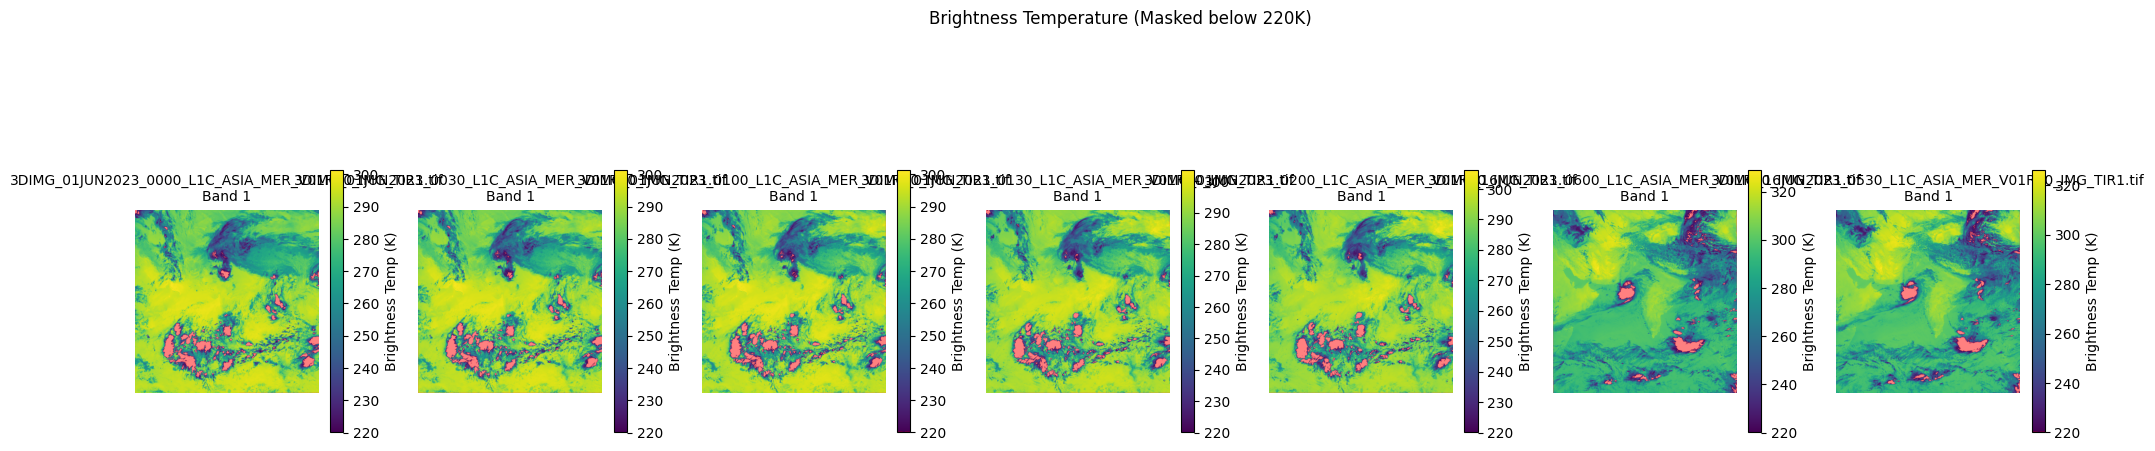

Data saved to: output

Extracted data for 7 files


In [15]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
from matplotlib.colors import ListedColormap

class TIFF3DExtractor:
    """
    TIFF extractor with masking for brightness temperature values
    """
    
    def __init__(self):
        self.metadata = {}
        self.data = None
        self.bands_info = []
        self.masked_data = None
        
    def extract_data(self, filepath):
        """
        Extract data using rasterio for a single file
        """
        print(f"Reading file: {filepath}")
        
        with rasterio.open(filepath) as src:
            # Basic file information
            print("=== FILE INFORMATION ===")
            print(f"Dimensions: {src.width} x {src.height}")
            print(f"Number of bands: {src.count}")
            print(f"Data type: {src.dtypes[0]}")
            print(f"CRS: {src.crs}")
            print(f"Bounds: {src.bounds}")
            
            # Read all bands
            data = src.read()  # Shape: (bands, height, width)
            print(f"Data shape: {data.shape}")
            print(f"Data range: {data.min()} to {data.max()}")
            
            # Store metadata
            file_metadata = {
                'filename': os.path.basename(filepath),
                'width': src.width,
                'height': src.height,
                'count': src.count,
                'dtype': str(src.dtypes[0]),
                'crs': str(src.crs),
                'bounds': src.bounds,
                'transform': src.transform,
                'nodata': src.nodata
            }
            
            # Analyze each band
            print("\n=== BAND ANALYSIS ===")
            bands_info = []
            for i in range(src.count):
                band_data = data[i]
                band_info = {
                    'filename': os.path.basename(filepath),
                    'band_number': i + 1,
                    'min': float(band_data.min()),
                    'max': float(band_data.max()),
                    'mean': float(np.mean(band_data)),
                    'std': float(np.std(band_data))
                }
                
                bands_info.append(band_info)
                print(f"Band {i+1}: Range {band_info['min']:.2f} - {band_info['max']:.2f}, Mean: {band_info['mean']:.2f}")
            
            return data, file_metadata, bands_info
    
    def apply_tb_mask(self, data, threshold=220):
        """
        Apply brightness temperature mask (mask values below threshold)
        Returns masked array and transparency mask
        """
        # Create mask (True where values are below threshold)
        mask = data < threshold
        # Create masked array
        masked_data = np.ma.masked_where(mask, data)
        # Create transparency mask (0 = transparent, 1 = opaque)
        transparency_mask = np.where(mask, 0, 1).astype(float)
        
        return masked_data, transparency_mask
    
    def visualize_files_single_row(self, filepaths, max_bands_per_file=12, figsize=(20, 5), tb_threshold=220):
        """
        Visualize bands from multiple files in a single row with Tb masking
        """
        total_bands = 0
        all_band_data = []
        all_masked_data = []
        band_labels = []
        
        # Custom colormap with transparent first color
        cmap = plt.cm.viridis
        cmap.set_bad('red', alpha=0.5)  # Color for masked values
        
        # Collect all band data and labels
        for filepath in filepaths:
            data, _, _ = self.extract_data(filepath)
            n_bands = min(data.shape[0], max_bands_per_file)
            
            for j in range(n_bands):
                band_data = data[j]
                masked_data, _ = self.apply_tb_mask(band_data, tb_threshold)
                
                all_band_data.append(band_data)
                all_masked_data.append(masked_data)
                band_labels.append(f"{os.path.basename(filepath)}\nBand {j+1}")
                total_bands += 1
        
        # Create figure with one row
        fig, axes = plt.subplots(1, total_bands, figsize=figsize)
        
        if total_bands == 1:
            axes = [axes]
        
        # Plot each band with masked values
        for i in range(total_bands):
            # Plot original data with masked values
            im = axes[i].imshow(all_masked_data[i], cmap=cmap, vmin=tb_threshold)
            
            # Add title and turn off axis
            axes[i].set_title(band_labels[i], fontsize=10)
            axes[i].axis('off')
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=axes[i], shrink=0.6)
            cbar.set_label('Brightness Temp (K)')
            
            # Add threshold indicator to colorbar
            cbar.ax.axhline(tb_threshold, color='red', linestyle='--', linewidth=1)
        
        plt.suptitle(f"Brightness Temperature (Masked below {tb_threshold}K)", y=1.05)
        plt.tight_layout()
        plt.show()
        
        # Store the masked data
        self.masked_data = all_masked_data
    
    def save_data(self, output_dir):
        """
        Save extracted data and metadata
        """
        if not self.data:
            print("No data to save")
            return
        
        os.makedirs(output_dir, exist_ok=True)
        
        # Save original data as compressed numpy array
        np.savez_compressed(
            os.path.join(output_dir, 'tiff_data.npz'),
            data=self.data,
            metadata=self.metadata
        )
        
        # Save masked data if available
        if self.masked_data is not None:
            np.savez_compressed(
                os.path.join(output_dir, 'masked_data.npz'),
                masked_data=self.masked_data,
                metadata=self.metadata
            )
        
        # Save band information as CSV
        df = pd.DataFrame(self.bands_info)
        df.to_csv(os.path.join(output_dir, 'bands_info.csv'), index=False)
        
        # Save metadata as JSON
        with open(os.path.join(output_dir, 'metadata.json'), 'w') as f:
            json.dump(self.metadata, f, indent=2, default=str)
        
        print(f"Data saved to: {output_dir}")
    
    def process_files(self, filepaths, output_dir=None, visualize=True, single_row=True, tb_threshold=220):
        """
        Complete processing pipeline for multiple files with Tb masking
        """
        all_data = []
        all_metadata = []
        all_bands_info = []
        
        for filepath in filepaths:
            data, metadata, bands_info = self.extract_data(filepath)
            all_data.append(data)
            all_metadata.append(metadata)
            all_bands_info.extend(bands_info)
        
        # Store everything in the instance
        self.data = all_data
        self.metadata = all_metadata
        self.bands_info = all_bands_info
        
        # Visualize if requested
        if visualize:
            if single_row:
                self.visualize_files_single_row(filepaths, tb_threshold=tb_threshold)
            else:
                self.visualize_files(filepaths)
        
        # Save if output directory provided
        if output_dir:
            self.save_data(output_dir)
        
        return all_data

# Usage
if __name__ == "__main__":
    extractor = TIFF3DExtractor()
    
    # Process multiple TIFF files
    filepaths = [
        "3DIMG_01JUN2023_0000_L1C_ASIA_MER_V01R00_IMG_TIR1.tif",
        "3DIMG_01JUN2023_0030_L1C_ASIA_MER_V01R00_IMG_TIR1.tif",
        "3DIMG_01JUN2023_0100_L1C_ASIA_MER_V01R00_IMG_TIR1.tif",
        "3DIMG_01JUN2023_0130_L1C_ASIA_MER_V01R00_IMG_TIR1.tif",
        "3DIMG_01JUN2023_0200_L1C_ASIA_MER_V01R00_IMG_TIR1.tif",
        "3DIMG_16JUN2023_0600_L1C_ASIA_MER_V01R00_IMG_TIR1.tif",
        "3DIMG_16JUN2023_0530_L1C_ASIA_MER_V01R00_IMG_TIR1.tif",
        
    ]
    
    # Filter to only existing files
    filepaths = [f for f in filepaths if os.path.exists(f)]
    
    if not filepaths:
        print("No valid files found to process")
    else:
        # Process with Tb threshold of 220K
        data = extractor.process_files(
            filepaths, 
            output_dir="output", 
            visualize=True, 
            single_row=True,
            tb_threshold=220
        )
        print(f"\nExtracted data for {len(data)} files")

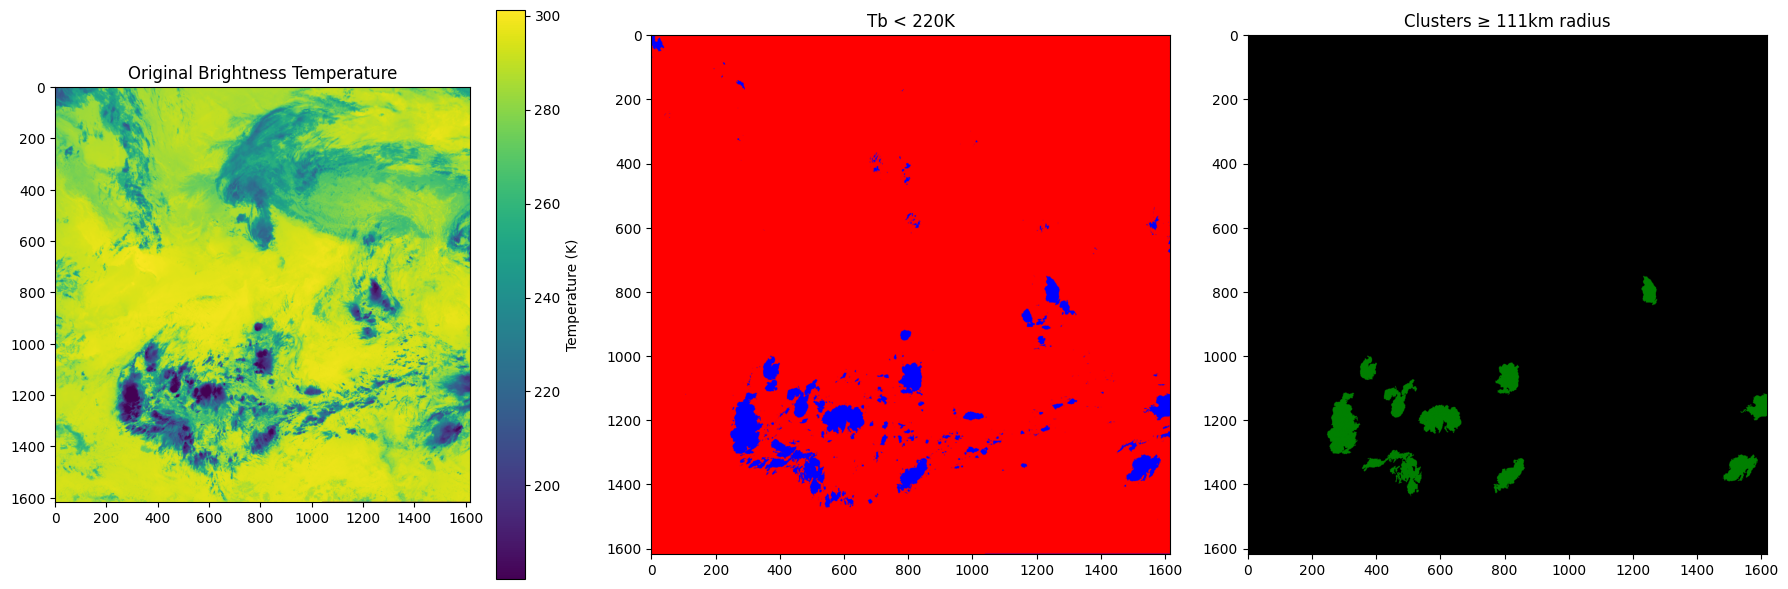

Analysis complete. Results saved to cloud_clusters.tif


In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from matplotlib.colors import ListedColormap

class CloudClusterAnalyzer:
    """
    Analyzes cloud clusters based on brightness temperature and size criteria
    """
    
    def __init__(self, estimated_km_per_pixel=4.0):
        """
        Initialize with estimated km per pixel (default: 4km/pixel for INSAT-3D)
        """
        self.estimated_km_per_pixel = estimated_km_per_pixel
        self.data = None
        self.metadata = {}
        self.tb_threshold = 220  # Default brightness temperature threshold
        self.min_radius_km = 111  # Minimum radius threshold in km
        
    def load_tiff(self, filepath):
        """Load TIFF file using rasterio"""
        with rasterio.open(filepath) as src:
            self.data = src.read(1)  # Read first band
            self.metadata = {
                'transform': src.transform,
                'crs': src.crs,
                'width': src.width,
                'height': src.height
            }
        return self.data
    
    def apply_tb_mask(self, data=None, threshold=None):
        """Apply brightness temperature mask"""
        if data is None:
            data = self.data
        if threshold is None:
            threshold = self.tb_threshold
        
        # Create mask (True where values are below threshold - cold clouds)
        tb_mask = data < threshold
        return tb_mask
    
    def apply_size_filter(self, mask, min_radius_km=None):
        """Apply size filter to mask"""
        if min_radius_km is None:
            min_radius_km = self.min_radius_km
        
        # Calculate minimum area in pixels
        min_area_pixels = np.pi * (min_radius_km / self.estimated_km_per_pixel)**2
        
        # Label connected regions
        labeled = label(mask)
        
        # Create valid mask
        valid_mask = np.zeros_like(mask, dtype=bool)
        
        for region in regionprops(labeled):
            if region.area >= min_area_pixels:
                valid_mask[labeled == region.label] = True
                
        return valid_mask
    
    def analyze_clusters(self, filepath, tb_threshold=220, min_radius_km=111):
        """Complete analysis pipeline"""
        # Load and set parameters
        self.load_tiff(filepath)
        self.tb_threshold = tb_threshold
        self.min_radius_km = min_radius_km
        
        # Step 1: Apply temperature threshold
        tb_mask = self.apply_tb_mask()
        
        # Step 2: Apply size filter
        final_mask = self.apply_size_filter(tb_mask)
        
        return final_mask
    
    def visualize_results(self, original_data, tb_mask, final_mask):
        """Visualize the processing steps"""
        # Create colormaps
        tb_cmap = ListedColormap(['red', 'blue'])
        final_cmap = ListedColormap(['black', 'green'])
        
        # Create figure
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original data
        im1 = ax1.imshow(original_data, cmap='viridis')
        ax1.set_title('Original Brightness Temperature')
        plt.colorbar(im1, ax=ax1, label='Temperature (K)')
        
        # After temperature threshold
        im2 = ax2.imshow(tb_mask, cmap=tb_cmap)
        ax2.set_title(f'Tb < {self.tb_threshold}K')
        
        # After size filtering
        im3 = ax3.imshow(final_mask, cmap=final_cmap)
        ax3.set_title(f'Clusters ≥ {self.min_radius_km}km radius')
        
        plt.tight_layout()
        plt.show()
        
    def save_results(self, output_path, final_mask):
        """Save the final mask as a TIFF file"""
        # Convert boolean mask to uint8 (0 and 1)
        mask_uint8 = final_mask.astype(np.uint8)
        
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=mask_uint8.shape[0],
            width=mask_uint8.shape[1],
            count=1,
            dtype='uint8',
            crs=self.metadata['crs'],
            transform=self.metadata['transform']
        ) as dst:
            dst.write(mask_uint8, 1)

# Example usage
if __name__ == "__main__":
    # Initialize analyzer with estimated km/pixel resolution
    analyzer = CloudClusterAnalyzer(estimated_km_per_pixel=4.0)
    
    # Input file and output path
    input_file = "3DIMG_01JUN2023_0100_L1C_ASIA_MER_V01R00_IMG_TIR1.tif"
    output_file = "cloud_clusters.tif"
    
    # Run analysis
    final_mask = analyzer.analyze_clusters(
        input_file,
        tb_threshold=220,  # Temperature threshold in Kelvin
        min_radius_km=111  # Minimum cluster radius in km
    )
    
    # Visualize results
    analyzer.visualize_results(analyzer.data, 
                             analyzer.apply_tb_mask(), 
                             final_mask)
    
    # Save results
    analyzer.save_results(output_file, final_mask)
    
    print(f"Analysis complete. Results saved to {output_file}")

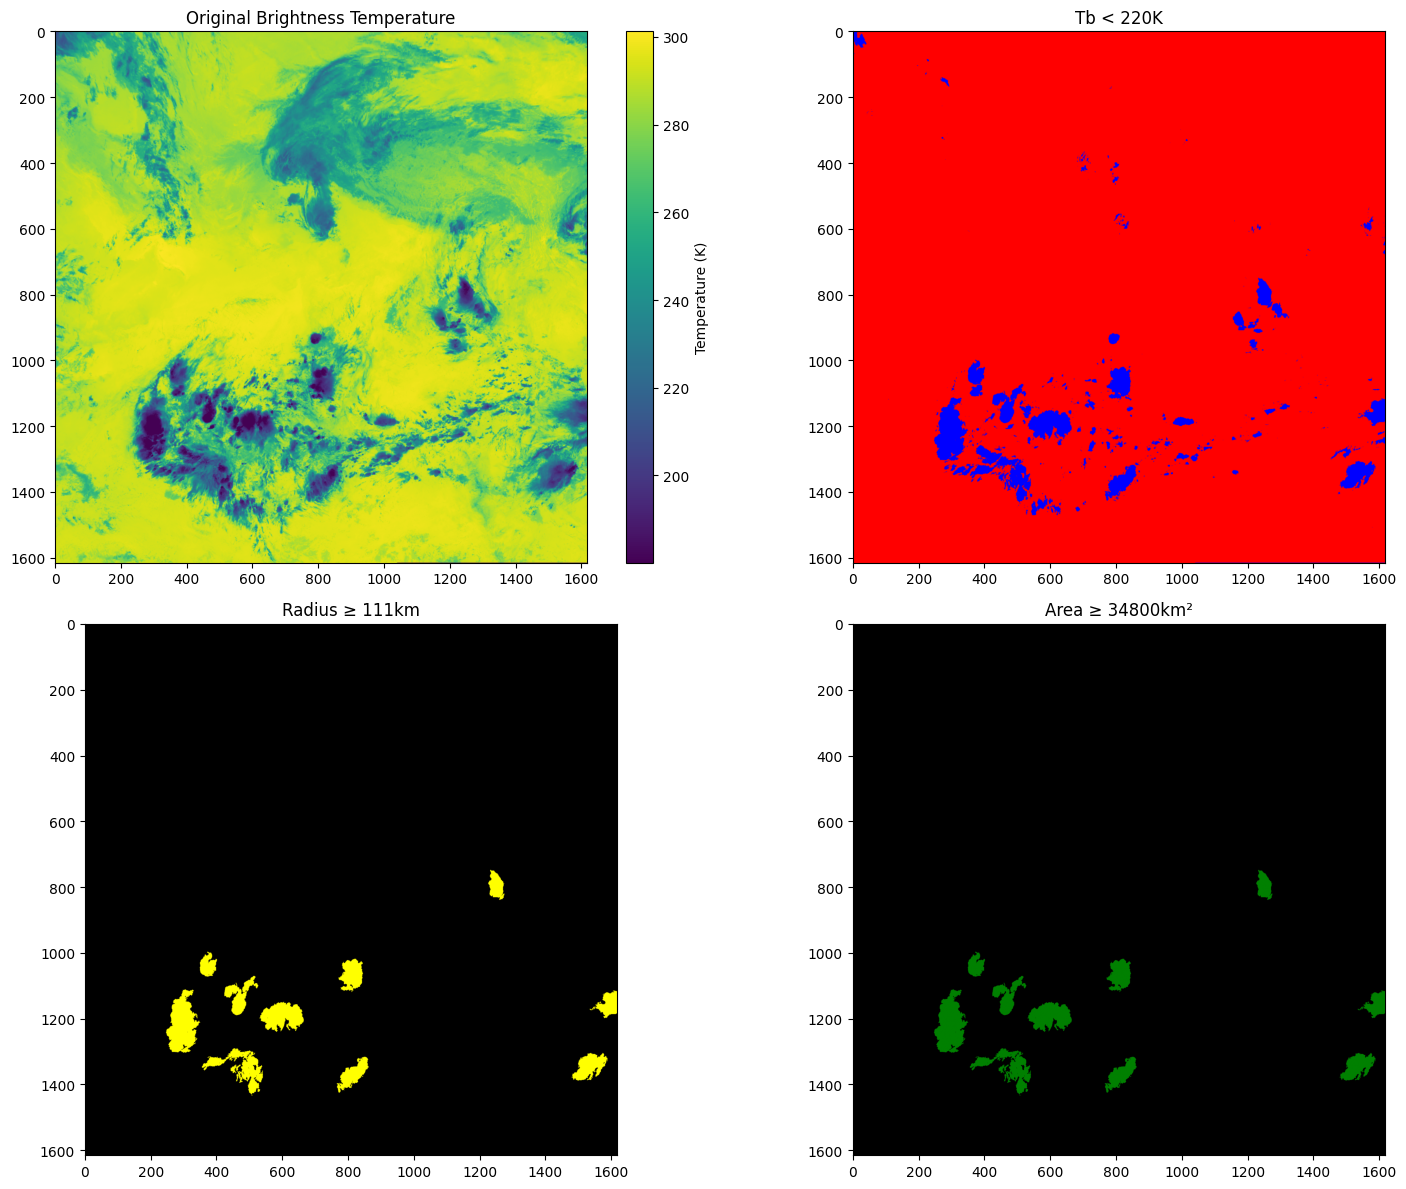

Analysis complete. Results saved to cloud_clusters.tif


In [4]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from matplotlib.colors import ListedColormap

class CloudClusterAnalyzer:
    """
    Analyzes cloud clusters based on brightness temperature and size criteria
    """
    
    def __init__(self, estimated_km_per_pixel=4.0):
        """
        Initialize with estimated km per pixel (default: 4km/pixel for INSAT-3D)
        """
        self.estimated_km_per_pixel = estimated_km_per_pixel
        self.data = None
        self.metadata = {}
        self.tb_threshold = 220  # Default brightness temperature threshold
        self.min_radius_km = 111  # Minimum radius threshold in km
        self.min_area_km2 = 34800  # Minimum area threshold in km²
        
    def load_tiff(self, filepath):
        """Load TIFF file using rasterio"""
        with rasterio.open(filepath) as src:
            self.data = src.read(1)  # Read first band
            self.metadata = {
                'transform': src.transform,
                'crs': src.crs,
                'width': src.width,
                'height': src.height
            }
        return self.data
    
    def apply_tb_mask(self, data=None, threshold=None):
        """Apply brightness temperature mask"""
        if data is None:
            data = self.data
        if threshold is None:
            threshold = self.tb_threshold
        
        # Create mask (True where values are below threshold - cold clouds)
        tb_mask = data < threshold
        return tb_mask
    
    def apply_size_filter(self, mask, min_radius_km=None):
        """Apply size filter to mask"""
        if min_radius_km is None:
            min_radius_km = self.min_radius_km
        
        # Calculate minimum area in pixels
        min_area_pixels = np.pi * (min_radius_km / self.estimated_km_per_pixel)**2
        
        # Label connected regions
        labeled = label(mask)
        
        # Create valid mask
        valid_mask = np.zeros_like(mask, dtype=bool)
        
        for region in regionprops(labeled):
            if region.area >= min_area_pixels:
                valid_mask[labeled == region.label] = True
                
        return valid_mask
    
    def apply_area_filter(self, mask, min_area_km2=None):
        """Apply area filter to mask (filters out non-circular convective structures)"""
        if min_area_km2 is None:
            min_area_km2 = self.min_area_km2
        
        # Calculate minimum area in pixels
        min_area_pixels = min_area_km2 / (self.estimated_km_per_pixel ** 2)
        
        # Label connected regions
        labeled = label(mask)
        
        # Create valid mask
        valid_mask = np.zeros_like(mask, dtype=bool)
        
        for region in regionprops(labeled):
            if region.area >= min_area_pixels:
                valid_mask[labeled == region.label] = True
                
        return valid_mask
    
    def analyze_clusters(self, filepath, tb_threshold=220, min_radius_km=111, min_area_km2=34800):
        """Complete analysis pipeline"""
        # Load and set parameters
        self.load_tiff(filepath)
        self.tb_threshold = tb_threshold
        self.min_radius_km = min_radius_km
        self.min_area_km2 = min_area_km2
        
        # Step 1: Apply temperature threshold
        tb_mask = self.apply_tb_mask()
        
        # Step 2: Apply size filter (radius constraint)
        radius_filtered_mask = self.apply_size_filter(tb_mask)
        
        # Step 3: Apply area filter (to filter out non-circular convective structures)
        final_mask = self.apply_area_filter(radius_filtered_mask)
        
        return final_mask
    
    def visualize_results(self, original_data, tb_mask, radius_filtered_mask, final_mask):
        """Visualize the processing steps"""
        # Create colormaps
        tb_cmap = ListedColormap(['red', 'blue'])
        radius_cmap = ListedColormap(['black', 'yellow'])
        final_cmap = ListedColormap(['black', 'green'])
        
        # Create figure
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Original data
        im1 = axes[0,0].imshow(original_data, cmap='viridis')
        axes[0,0].set_title('Original Brightness Temperature')
        plt.colorbar(im1, ax=axes[0,0], label='Temperature (K)')
        
        # After temperature threshold
        im2 = axes[0,1].imshow(tb_mask, cmap=tb_cmap)
        axes[0,1].set_title(f'Tb < {self.tb_threshold}K')
        
        # After radius filtering
        im3 = axes[1,0].imshow(radius_filtered_mask, cmap=radius_cmap)
        axes[1,0].set_title(f'Radius ≥ {self.min_radius_km}km')
        
        # After area filtering (final)
        im4 = axes[1,1].imshow(final_mask, cmap=final_cmap)
        axes[1,1].set_title(f'Area ≥ {self.min_area_km2}km²')
        
        plt.tight_layout()
        plt.show()
        
    def save_results(self, output_path, final_mask):
        """Save the final mask as a TIFF file"""
        # Convert boolean mask to uint8 (0 and 1)
        mask_uint8 = final_mask.astype(np.uint8)
        
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=mask_uint8.shape[0],
            width=mask_uint8.shape[1],
            count=1,
            dtype='uint8',
            crs=self.metadata['crs'],
            transform=self.metadata['transform']
        ) as dst:
            dst.write(mask_uint8, 1)

# Example usage
if __name__ == "__main__":
    # Initialize analyzer with estimated km/pixel resolution
    analyzer = CloudClusterAnalyzer(estimated_km_per_pixel=4.0)
    
    # Input file and output path
    input_file = "3DIMG_01JUN2023_0100_L1C_ASIA_MER_V01R00_IMG_TIR1.tif"
    output_file = "cloud_clusters.tif"
    
    # Run analysis
    final_mask = analyzer.analyze_clusters(
        input_file,
        tb_threshold=220,  # Temperature threshold in Kelvin
        min_radius_km=111,  # Minimum cluster radius in km
        min_area_km2=34800  # Minimum area in km² (~90% of 1° radius circle)
    )
    
    # Visualize results (now showing all processing steps)
    tb_mask = analyzer.apply_tb_mask()
    radius_filtered_mask = analyzer.apply_size_filter(tb_mask)
    analyzer.visualize_results(analyzer.data, 
                             tb_mask,
                             radius_filtered_mask,
                             final_mask)
    
    # Save results
    analyzer.save_results(output_file, final_mask)
    
    print(f"Analysis complete. Results saved to {output_file}")

Identified 2 TCC candidates

=== TCC CANDIDATES SUMMARY ===
Total TCC candidates found: 2
Temperature threshold: 220K
Minimum radius: 111 km
Minimum area: 34800 km²

Individual TCC Details:
--------------------------------------------------------------------------------
TCC ID   Area (km²)   Radius (km)  Centroid (row,col)   Eccentricity
--------------------------------------------------------------------------------
1        171632       233.7        (736.7,647.4)        0.771       
2        294160       306.0        (1196.3,1177.8)      0.898       


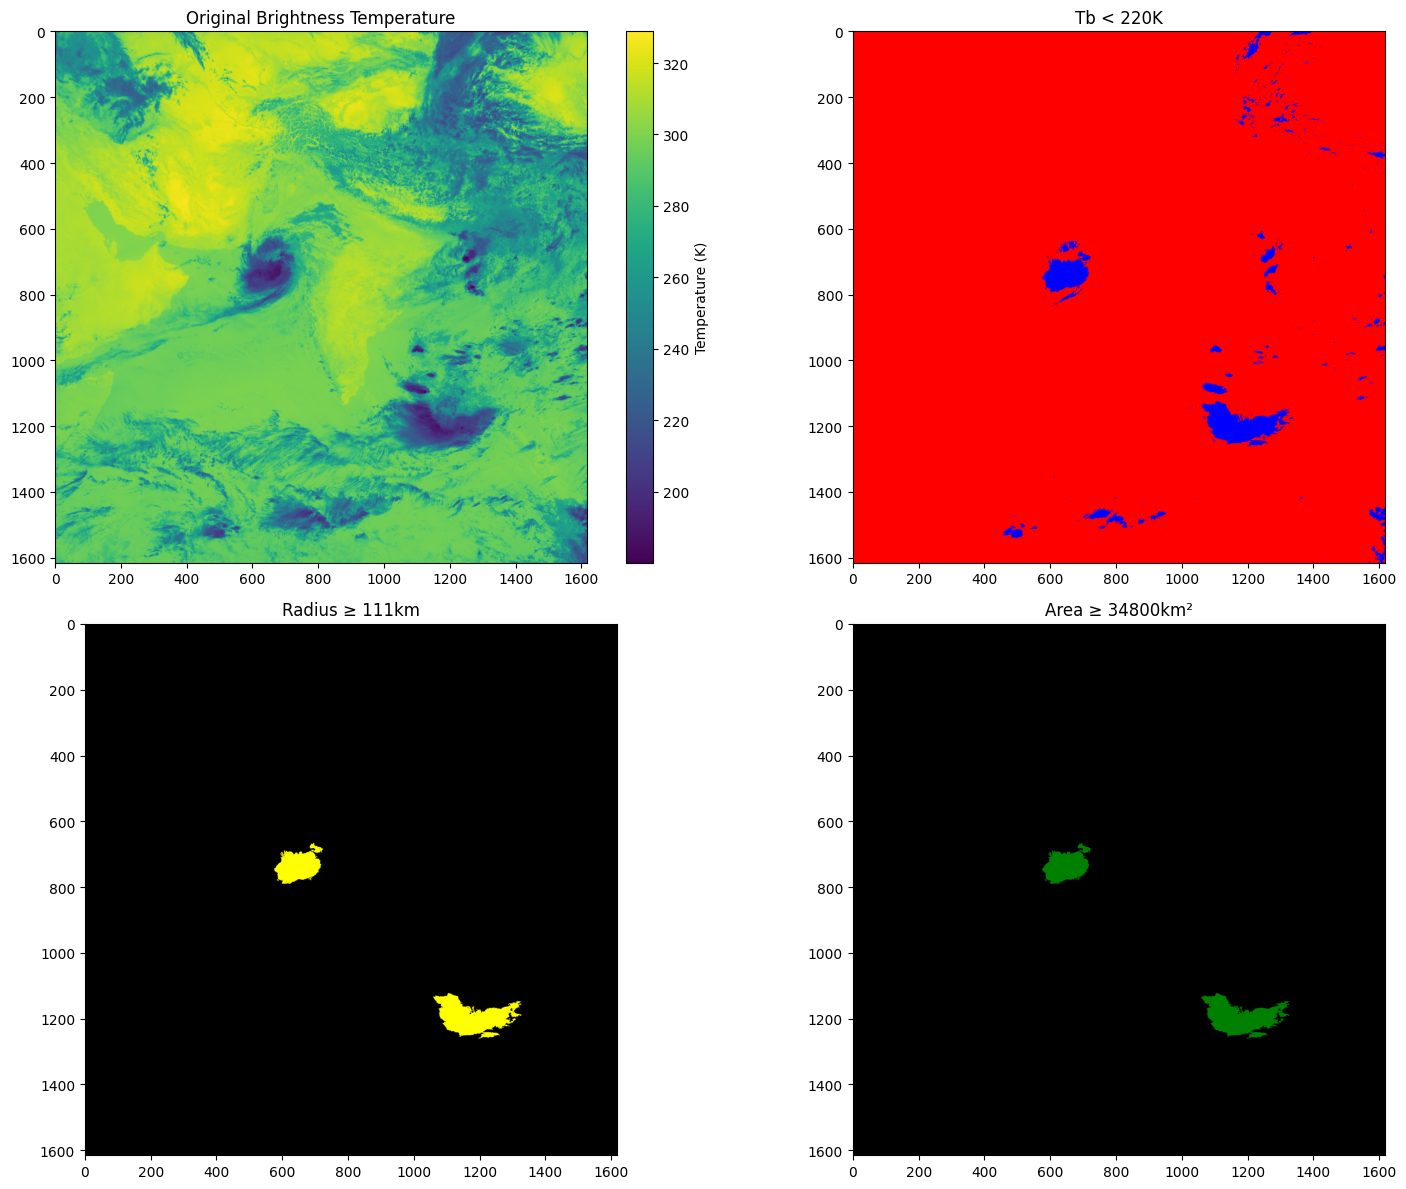

Analysis complete. Results saved to cloud_clusters.tif
TCC labels saved to tcc_candidates_labeled.tif


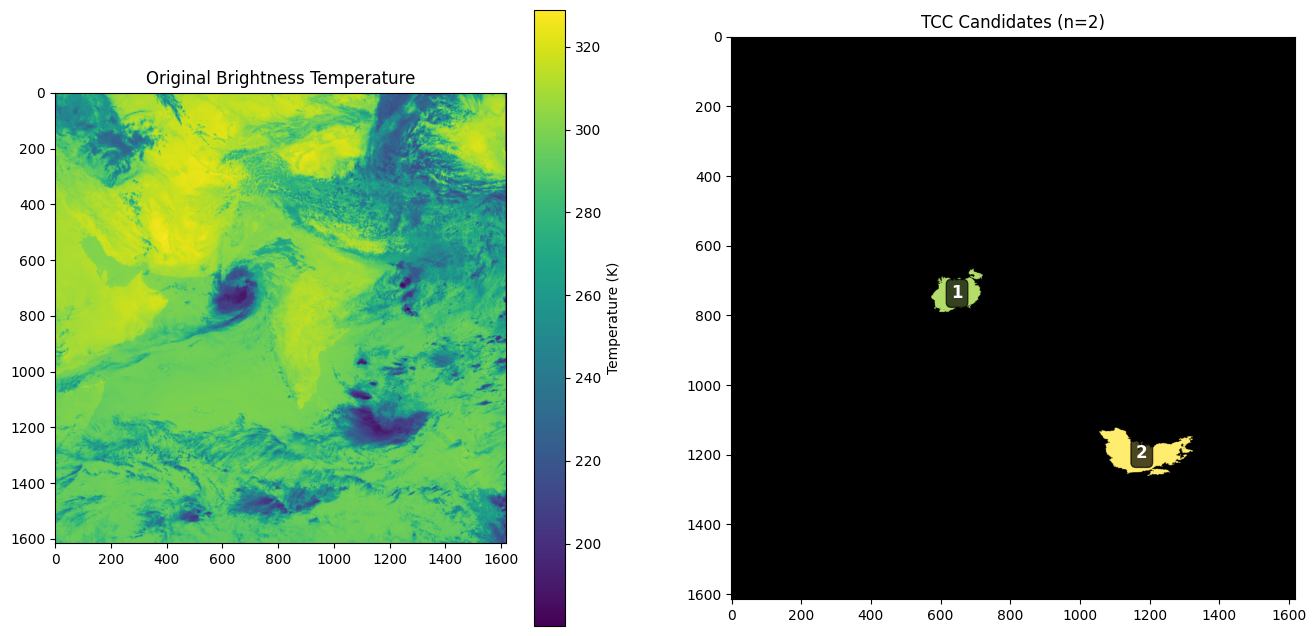

In [8]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from matplotlib.colors import ListedColormap

class CloudClusterAnalyzer:
    """
    Analyzes cloud clusters based on brightness temperature and size criteria
    """
    
    def __init__(self, estimated_km_per_pixel=4.0):
        """
        Initialize with estimated km per pixel (default: 4km/pixel for INSAT-3D)
        """
        self.estimated_km_per_pixel = estimated_km_per_pixel
        self.data = None
        self.metadata = {}
        self.tb_threshold = 220  # Default brightness temperature threshold
        self.min_radius_km = 111  # Minimum radius threshold in km
        self.min_area_km2 = 34800  # Minimum area threshold in km²
        self.tcc_labels = None  # Will store labeled TCC candidates
        self.tcc_properties = None  # Will store TCC properties
        
    def load_tiff(self, filepath):
        """Load TIFF file using rasterio"""
        with rasterio.open(filepath) as src:
            self.data = src.read(1)  # Read first band
            self.metadata = {
                'transform': src.transform,
                'crs': src.crs,
                'width': src.width,
                'height': src.height
            }
        return self.data
    
    def apply_tb_mask(self, data=None, threshold=None):
        """Apply brightness temperature mask"""
        if data is None:
            data = self.data
        if threshold is None:
            threshold = self.tb_threshold
        
        # Create mask (True where values are below threshold - cold clouds)
        tb_mask = data < threshold
        return tb_mask
    
    def apply_size_filter(self, mask, min_radius_km=None):
        """Apply size filter to mask"""
        if min_radius_km is None:
            min_radius_km = self.min_radius_km
        
        # Calculate minimum area in pixels
        min_area_pixels = np.pi * (min_radius_km / self.estimated_km_per_pixel)**2
        
        # Label connected regions
        labeled = label(mask)
        
        # Create valid mask
        valid_mask = np.zeros_like(mask, dtype=bool)
        
        for region in regionprops(labeled):
            if region.area >= min_area_pixels:
                valid_mask[labeled == region.label] = True
                
        return valid_mask
    
    def apply_area_filter(self, mask, min_area_km2=None):
        """Apply area filter to mask (filters out non-circular convective structures)"""
        if min_area_km2 is None:
            min_area_km2 = self.min_area_km2
        
        # Calculate minimum area in pixels
        min_area_pixels = min_area_km2 / (self.estimated_km_per_pixel ** 2)
        
        # Label connected regions
        labeled = label(mask)
        
        # Create valid mask
        valid_mask = np.zeros_like(mask, dtype=bool)
        
        for region in regionprops(labeled):
            if region.area >= min_area_pixels:
                valid_mask[labeled == region.label] = True
                
        return valid_mask
    
    def analyze_clusters(self, filepath, tb_threshold=220, min_radius_km=111, min_area_km2=34800):
        """Complete analysis pipeline"""
        # Load and set parameters
        self.load_tiff(filepath)
        self.tb_threshold = tb_threshold
        self.min_radius_km = min_radius_km
        self.min_area_km2 = min_area_km2
        
        # Step 1: Apply temperature threshold
        tb_mask = self.apply_tb_mask()
        
        # Step 2: Apply size filter (radius constraint)
        radius_filtered_mask = self.apply_size_filter(tb_mask)
        
        # Step 3: Apply area filter (to filter out non-circular convective structures)
        final_mask = self.apply_area_filter(radius_filtered_mask)
        
        return final_mask
    
    def label_tcc_candidates(self, final_mask):
        """Label pixels as TCC candidates and extract properties"""
        # Label connected components
        self.tcc_labels = label(final_mask)
        
        # Extract properties of each TCC candidate
        regions = regionprops(self.tcc_labels)
        
        self.tcc_properties = []
        for i, region in enumerate(regions, 1):
            # Calculate properties in km and km²
            area_km2 = region.area * (self.estimated_km_per_pixel ** 2)
            equivalent_radius_km = np.sqrt(area_km2 / np.pi)
            
            tcc_info = {
                'tcc_id': i,
                'label': region.label,
                'area_pixels': region.area,
                'area_km2': area_km2,
                'equivalent_radius_km': equivalent_radius_km,
                'centroid_row': region.centroid[0],
                'centroid_col': region.centroid[1],
                'bbox': region.bbox,  # (min_row, min_col, max_row, max_col)
                'eccentricity': region.eccentricity,
                'solidity': region.solidity
            }
            self.tcc_properties.append(tcc_info)
        
        print(f"Identified {len(self.tcc_properties)} TCC candidates")
        return self.tcc_labels, self.tcc_properties
    
    def get_tcc_summary(self):
        """Print summary of TCC candidates"""
        if self.tcc_properties is None:
            print("No TCC analysis performed yet. Run label_tcc_candidates() first.")
            return
        
        print(f"\n=== TCC CANDIDATES SUMMARY ===")
        print(f"Total TCC candidates found: {len(self.tcc_properties)}")
        print(f"Temperature threshold: {self.tb_threshold}K")
        print(f"Minimum radius: {self.min_radius_km} km")
        print(f"Minimum area: {self.min_area_km2} km²")
        print("\nIndividual TCC Details:")
        print("-" * 80)
        print(f"{'TCC ID':<8} {'Area (km²)':<12} {'Radius (km)':<12} {'Centroid (row,col)':<20} {'Eccentricity':<12}")
        print("-" * 80)
        
        for tcc in self.tcc_properties:
            centroid_str = f"({tcc['centroid_row']:.1f},{tcc['centroid_col']:.1f})"
            print(f"{tcc['tcc_id']:<8} {tcc['area_km2']:<12.0f} {tcc['equivalent_radius_km']:<12.1f} "
                  f"{centroid_str:<20} {tcc['eccentricity']:<12.3f}")
    
    def visualize_tcc_candidates(self, original_data, show_labels=True):
        """Visualize TCC candidates with labels"""
        if self.tcc_labels is None:
            print("No TCC labels found. Run label_tcc_candidates() first.")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Original data
        im1 = ax1.imshow(original_data, cmap='viridis')
        ax1.set_title('Original Brightness Temperature')
        plt.colorbar(im1, ax=ax1, label='Temperature (K)')
        
        # TCC candidates with labels
        # Create colormap for labels (background=0 is black, labels get colors)
        n_labels = np.max(self.tcc_labels)
        colors = plt.cm.Set3(np.linspace(0, 1, n_labels + 1))
        colors[0] = [0, 0, 0, 1]  # Set background to black
        tcc_cmap = ListedColormap(colors)
        
        im2 = ax2.imshow(self.tcc_labels, cmap=tcc_cmap, vmin=0, vmax=n_labels)
        ax2.set_title(f'TCC Candidates (n={len(self.tcc_properties)})')
        
        # Add TCC ID labels on the plot
        if show_labels and self.tcc_properties:
            for tcc in self.tcc_properties:
                ax2.text(tcc['centroid_col'], tcc['centroid_row'], 
                        str(tcc['tcc_id']), 
                        ha='center', va='center', 
                        fontsize=12, fontweight='bold',
                        color='white', 
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
        
    def visualize_results(self, original_data, tb_mask, radius_filtered_mask, final_mask):
        """Visualize the processing steps"""
        # Create colormaps
        tb_cmap = ListedColormap(['red', 'blue'])
        radius_cmap = ListedColormap(['black', 'yellow'])
        final_cmap = ListedColormap(['black', 'green'])
        
        # Create figure
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Original data
        im1 = axes[0,0].imshow(original_data, cmap='viridis')
        axes[0,0].set_title('Original Brightness Temperature')
        plt.colorbar(im1, ax=axes[0,0], label='Temperature (K)')
        
        # After temperature threshold
        im2 = axes[0,1].imshow(tb_mask, cmap=tb_cmap)
        axes[0,1].set_title(f'Tb < {self.tb_threshold}K')
        
        # After radius filtering
        im3 = axes[1,0].imshow(radius_filtered_mask, cmap=radius_cmap)
        axes[1,0].set_title(f'Radius ≥ {self.min_radius_km}km')
        
        # After area filtering (final)
        im4 = axes[1,1].imshow(final_mask, cmap=final_cmap)
        axes[1,1].set_title(f'Area ≥ {self.min_area_km2}km²')
        
        plt.tight_layout()
        plt.show()
    
    def save_tcc_labels(self, output_path):
        """Save TCC labels as a TIFF file"""
        if self.tcc_labels is None:
            print("No TCC labels to save. Run label_tcc_candidates() first.")
            return
            
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=self.tcc_labels.shape[0],
            width=self.tcc_labels.shape[1],
            count=1,
            dtype='uint16',  # Use uint16 to accommodate more labels
            crs=self.metadata['crs'],
            transform=self.metadata['transform']
        ) as dst:
            dst.write(self.tcc_labels.astype(np.uint16), 1)
        """Visualize the processing steps"""
        # Create colormaps
        tb_cmap = ListedColormap(['red', 'blue'])
        radius_cmap = ListedColormap(['black', 'yellow'])
        final_cmap = ListedColormap(['black', 'green'])
        
        # Create figure
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Original data
        im1 = axes[0,0].imshow(original_data, cmap='viridis')
        axes[0,0].set_title('Original Brightness Temperature')
        plt.colorbar(im1, ax=axes[0,0], label='Temperature (K)')
        
        # After temperature threshold
        im2 = axes[0,1].imshow(tb_mask, cmap=tb_cmap)
        axes[0,1].set_title(f'Tb < {self.tb_threshold}K')
        
        # After radius filtering
        im3 = axes[1,0].imshow(radius_filtered_mask, cmap=radius_cmap)
        axes[1,0].set_title(f'Radius ≥ {self.min_radius_km}km')
        
        # After area filtering (final)
        im4 = axes[1,1].imshow(final_mask, cmap=final_cmap)
        axes[1,1].set_title(f'Area ≥ {self.min_area_km2}km²')
        
        plt.tight_layout()
        plt.show()
        
    def save_results(self, output_path, final_mask):
        """Save the final mask as a TIFF file"""
        # Convert boolean mask to uint8 (0 and 1)
        mask_uint8 = final_mask.astype(np.uint8)
        
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=mask_uint8.shape[0],
            width=mask_uint8.shape[1],
            count=1,
            dtype='uint8',
            crs=self.metadata['crs'],
            transform=self.metadata['transform']
        ) as dst:
            dst.write(mask_uint8, 1)

# Example usage
if __name__ == "__main__":
    # Initialize analyzer with estimated km/pixel resolution
    analyzer = CloudClusterAnalyzer(estimated_km_per_pixel=4.0)
    
    # Input file and output path
    input_file = "3DIMG_16JUN2023_0600_L1C_ASIA_MER_V01R00_IMG_TIR1.tif"
    output_file = "cloud_clusters.tif"
    
    # Run analysis
    final_mask = analyzer.analyze_clusters(
        input_file,
        tb_threshold=220,  # Temperature threshold in Kelvin
        min_radius_km=111,  # Minimum cluster radius in km
        min_area_km2=34800  # Minimum area in km² (~90% of 1° radius circle)
    )
    
    # Label TCC candidates
    tcc_labels, tcc_properties = analyzer.label_tcc_candidates(final_mask)
    
    # Print TCC summary
    analyzer.get_tcc_summary()
    
    # Visualize results (processing steps)
    tb_mask = analyzer.apply_tb_mask()
    radius_filtered_mask = analyzer.apply_size_filter(tb_mask)
    analyzer.visualize_results(analyzer.data, 
                             tb_mask,
                             radius_filtered_mask,
                             final_mask)
    
    # Visualize TCC candidates with labels
    analyzer.visualize_tcc_candidates(analyzer.data, show_labels=True)
    
    # Save results
    """ analyzer.save_results(output_file, final_mask)
    analyzer.save_tcc_labels("tcc_candidates_labeled.tif")"""
    
    print(f"Analysis complete. Results saved to {output_file}")
    print(f"TCC labels saved to tcc_candidates_labeled.tif")